In [12]:

library(dplyr)
library(ggplot2)
library(MCMCpack)
# library(gridExtra)
# library(stringr)
# library(tidyr)
# library(httr)
# library(jsonlite)
# library(lubridate)

In [13]:
wineFullData <- read.csv("data/winemag-data-130k-v2.csv")
glimpse(wineFullData)

Rows: 129,971
Columns: 14
$ X                     <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
$ country               <fct> Italy, Portugal, US, US, US, Spain, Italy, Fr...
$ description           <fct> "Aromas include tropical fruit, broom, brimst...
$ designation           <fct> VulkÃ  Bianco, Avidagos, , Reserve Late Harve...
$ points                <int> 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 8...
$ price                 <dbl> NA, 15, 14, 13, 65, 15, 16, 24, 12, 27, 19, 3...
$ province              <fct> Sicily & Sardinia, Douro, Oregon, Michigan, O...
$ region_1              <fct> Etna, , Willamette Valley, Lake Michigan Shor...
$ region_2              <fct> , , Willamette Valley, , Willamette Valley, ,...
$ taster_name           <fct> Kerin Oâ€™Keefe, Roger Voss, Paul Gregutt, Al...
$ taster_twitter_handle <fct> @kerinokeefe, @vossroger, @paulgwineÂ , , @pa...
$ title                 <fct> Nicosia 2013 VulkÃ  Bianco  (Etna), Quinta do...
$ variety               <f

In [14]:
#wine[wine$price == 15 ] , wine$variety == "Sauvignon Blanc"] || "Chardonnay"

wine <- wineFullData[ which((wineFullData$price == 15) & (((wineFullData$country == "South Africa") & (wineFullData$variety == "Sauvignon Blanc")) | ((wineFullData$country == "Chile") & (wineFullData$variety == "Chardonnay"))))  , ]

In [15]:
cat("Dimension for Sauvignon Blanc wines from South Africa and Chardonnay from Chile: " ,  dim(wine))

Dimension for Sauvignon Blanc wines from South Africa and Chardonnay from Chile:  51 14

In [16]:
wine$variety <- factor(wine$variety)

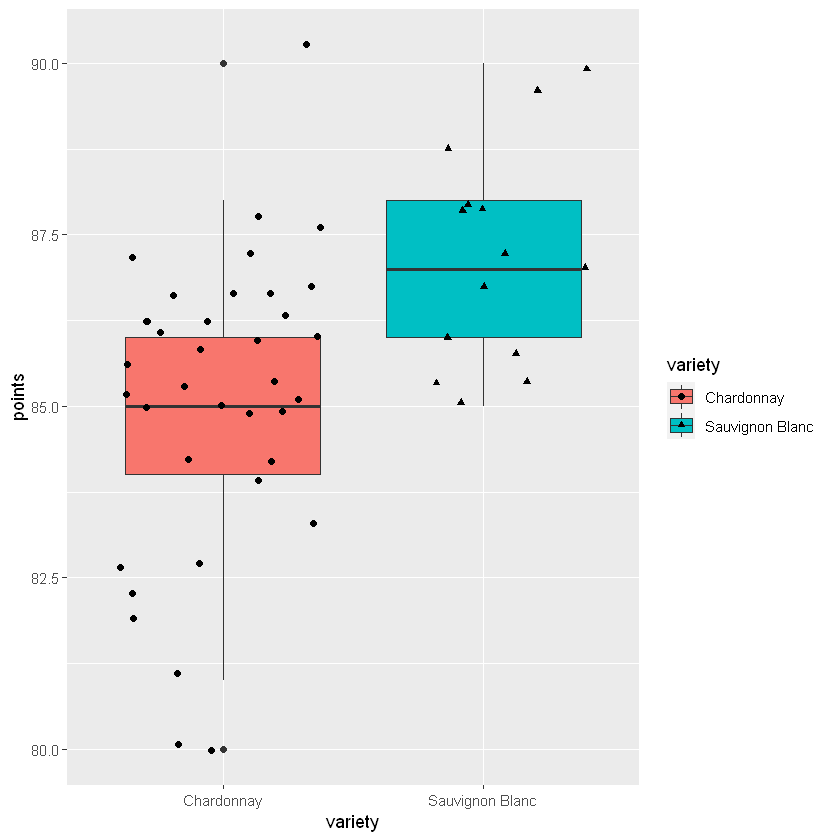

In [17]:
ggplot(wine) + geom_boxplot(aes(variety, points, fill = variety)) +
geom_jitter(aes(variety, points, shape = variety))

In [18]:
tapply(wine$points , wine$variety, mean)

Chardonnay Sauvignon Blanc 
       85.08108        87.21429

In [19]:
tapply(wine$points , wine$variety, median)

Chardonnay Sauvignon Blanc 
             85              87

In [20]:
tapply(wine$points , wine$variety, sd)

Chardonnay Sauvignon Blanc 
       2.203260        1.717716

In [21]:
t.test(points ~ variety, data=wine, var.equal = TRUE)



	Two Sample t-test

data:  points by variety
t = -3.2599, df = 49, p-value = 0.00203
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.4482245 -0.8181847
sample estimates:
     mean in group Chardonnay mean in group Sauvignon Blanc 
                     85.08108                      87.21429 


In [22]:
compare_2_gibbs <- function(y, ind, mu0 = 85, tau0 = 1/100, del0 = 0, gamma0 = 1/100,
a0 = 50, b0 = 1, maxiter = 5000)
{
y1 <- y[ind == 1]
y2 <- y[ind == 2]
n1 <- length(y1)
n2 <- length(y2)
##### starting values
mu <- (mean(y1) + mean(y2)) / 2
del <- (mean(y1) - mean(y2)) / 2
mat_store <- matrix(0, nrow = maxiter, ncol = 3)
#####
##### Gibbs sampler
an <- a0 + (n1 + n2)/2
for(s in 1 : maxiter)
{
##update tau
bn <- b0 + 0.5 * (sum((y1 - mu - del) ^ 2) + sum((y2 - mu + del) ^ 2))
tau <- rgamma(1, an, bn)
##
##update mu
taun <- tau0 + tau * (n1 + n2)
mun <- (tau0 * mu0 + tau * (sum(y1 - del) + sum(y2 + del))) / taun
mu <- rnorm(1, mun, sqrt(1/taun))
##
##update del
gamman <- tau0 + tau*(n1 + n2)
deln <- ( del0 * tau0 + tau * (sum(y1 - mu) - sum(y2 - mu))) / gamman
del<-rnorm(1, deln, sqrt(1/gamman))
##
## store parameter values
mat_store[s, ] <- c(mu, del, tau)
}
colnames(mat_store) <- c("mu", "del", "tau")
return(mat_store)
}

In [23]:
fit <- compare_2_gibbs(wine$points, as.factor(wine$variety))

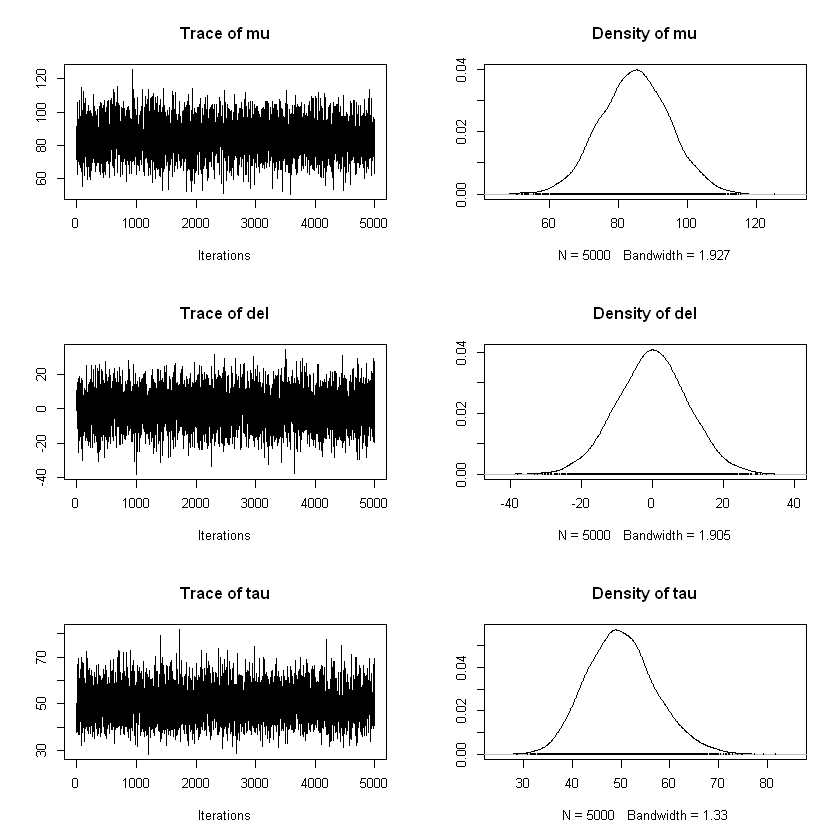

In [24]:
plot(as.mcmc(fit))


In [25]:
raftery.diag(as.mcmc(fit))



Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                           
     Burn-in  Total Lower bound  Dependence
     (M)      (N)   (Nmin)       factor (I)
 mu  2        3620  3746         0.966     
 del 2        3741  3746         0.999     
 tau 2        3561  3746         0.951     


In [26]:
apply(fit, 2, mean)

mu         del         tau 
84.81951597  0.05251937 50.11136505

In [27]:
apply(fit, 2, sd)

mu      del      tau 
9.984394 9.958055 7.017842

In [28]:
mean(1/sqrt(fit[, 3]))

[1] 0.1423095

In [29]:
sd(1/sqrt(fit[, 3]))

[1] 0.01004085

## Predictive distributions

In [30]:
y1_sim <- rnorm(5000, fit[, 1] + fit[, 2], sd = 1/sqrt(fit[, 3]))
y2_sim <- rnorm(5000, fit[, 1] - fit[, 2], sd = 1/sqrt(fit[, 3]))


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



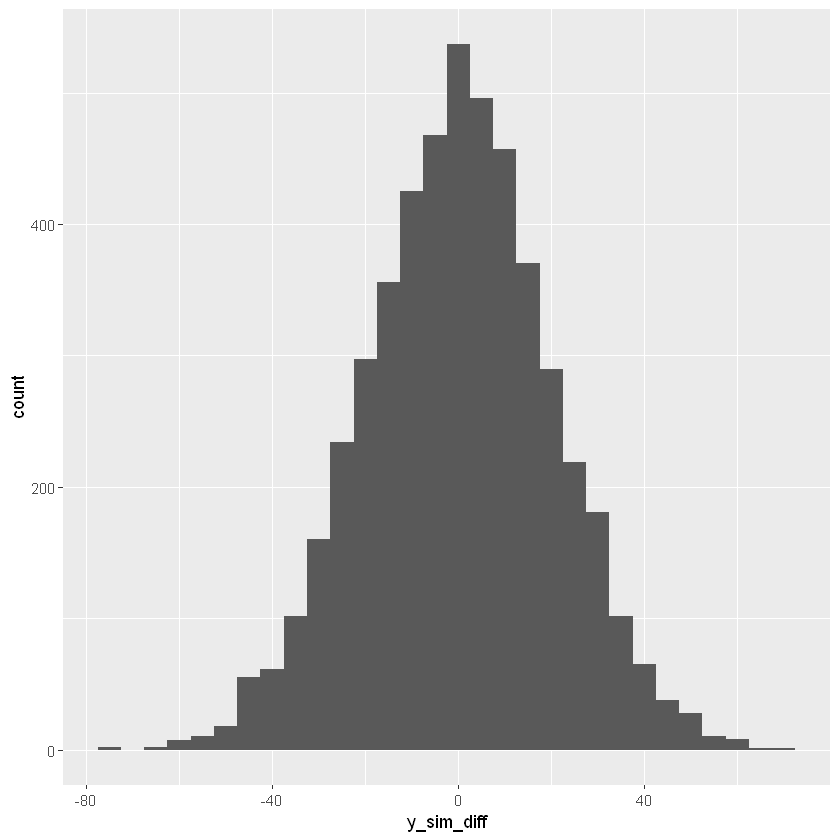

In [31]:
ggplot(data.frame(y_sim_diff = y1_sim - y2_sim)) + stat_bin(aes(y_sim_diff))


In [32]:
mean(y1_sim > y2_sim) #0.7 ===>>>>> 

[1] 0.5018

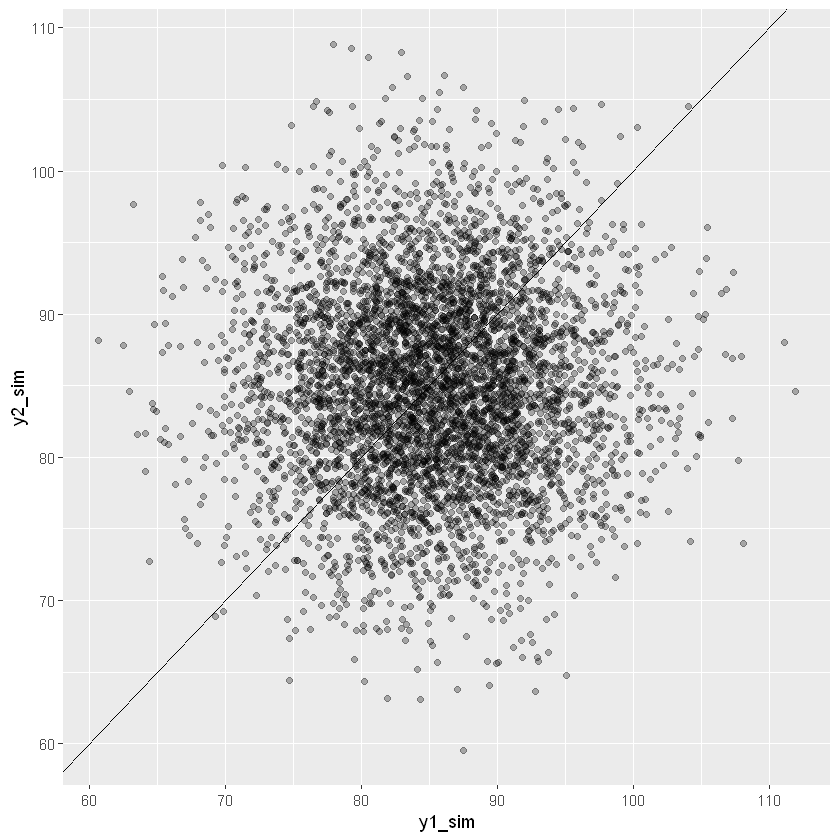

In [25]:
ggplot(data.frame(y1_sim, y2_sim)) + geom_point(aes(y1_sim, y2_sim), alpha = 0.3) +
geom_abline(slope = 1, intercept = 0)

### b. Consider the Italian wines in the dataset. Which regions produce better than average wine? Limit your analysis to wines costing less than €20 and to regions which have at least four such reviews. 

In [5]:
wine2 <- wineFullData[ which((wineFullData$price < 20) & (wineFullData$country == "Italy"))  , ]

In [6]:
wine2 <- wine2 %>%
  group_by(region_1) %>%
  filter(n() >= 4)

In [7]:
dim(wine2)

[1] 4702   14

In [8]:
wine2 <- droplevels(wine2)

In [9]:
wine2$region_1 <- as.factor(wine2$region_1)

wine2$points <- wine2$points + rnorm(nrow(wine2), 1, 1)/1000

In [10]:
nlevels(wine2$region_1)

[1] 163

ERROR while rich displaying an object: Error: Aesthetics must be either length 1 or the same as the data (4702): x

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.

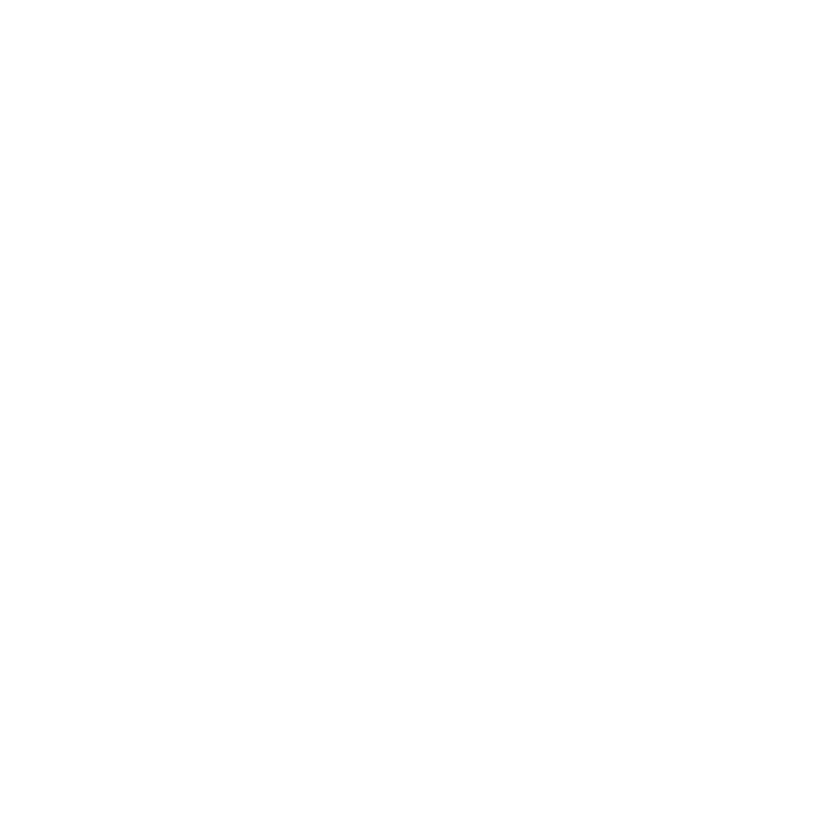

In [11]:
ggplot(wine2) + geom_boxplot(aes(x = reorder(region_1, points, median), points,
fill = reorder(region_1, points, median)), show.legend=FALSE)

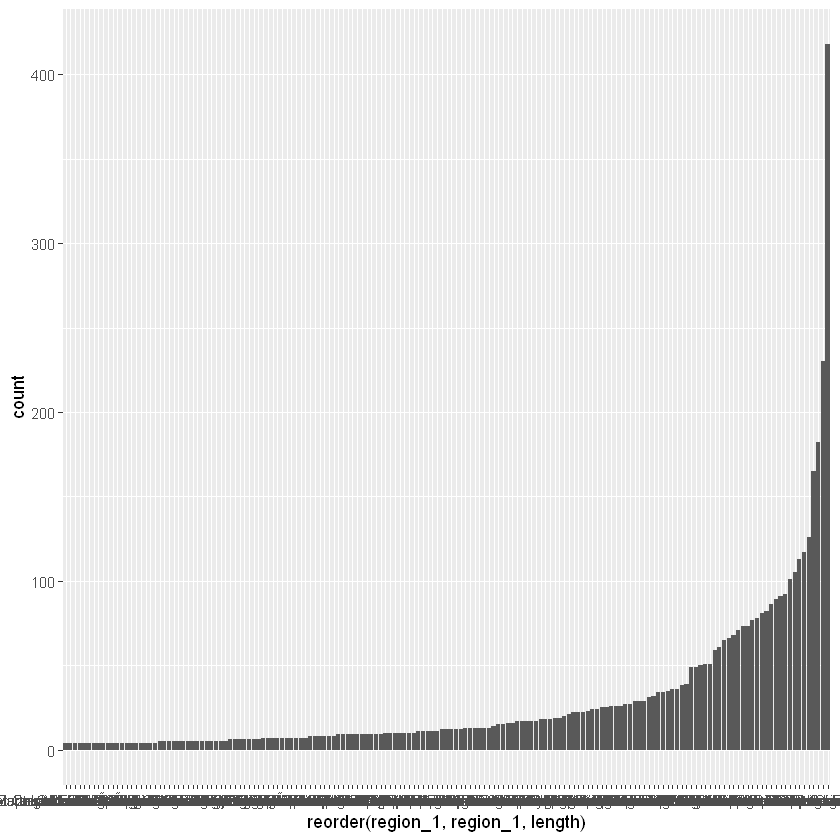

In [15]:
ggplot(wine2, aes(x = reorder(region_1, region_1, length))) + stat_count()


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



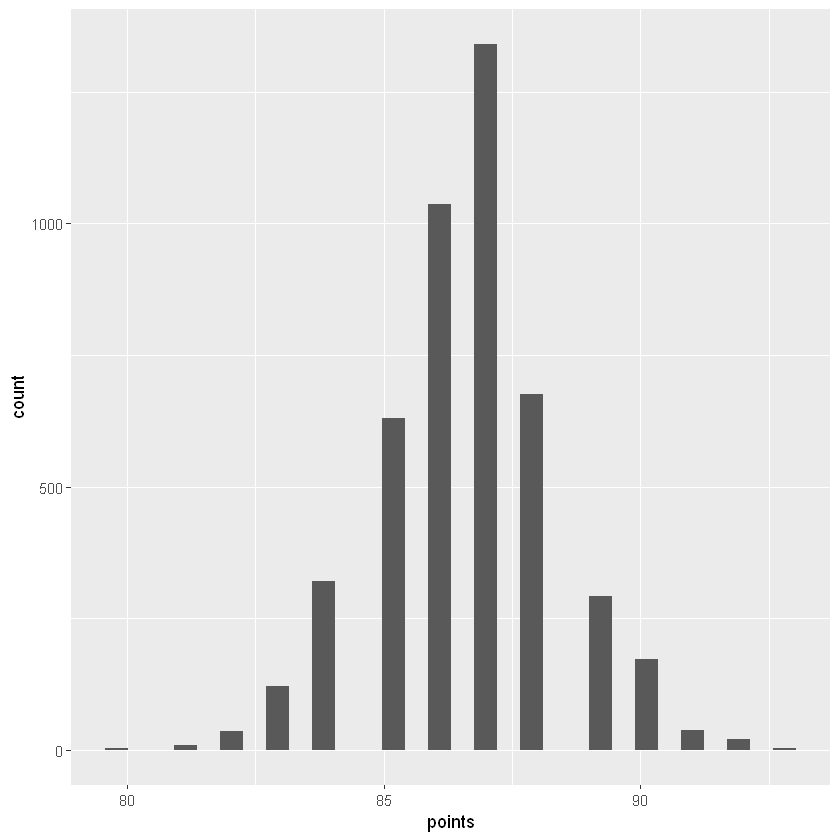

In [16]:
ggplot(wine2, aes(points)) + stat_bin()

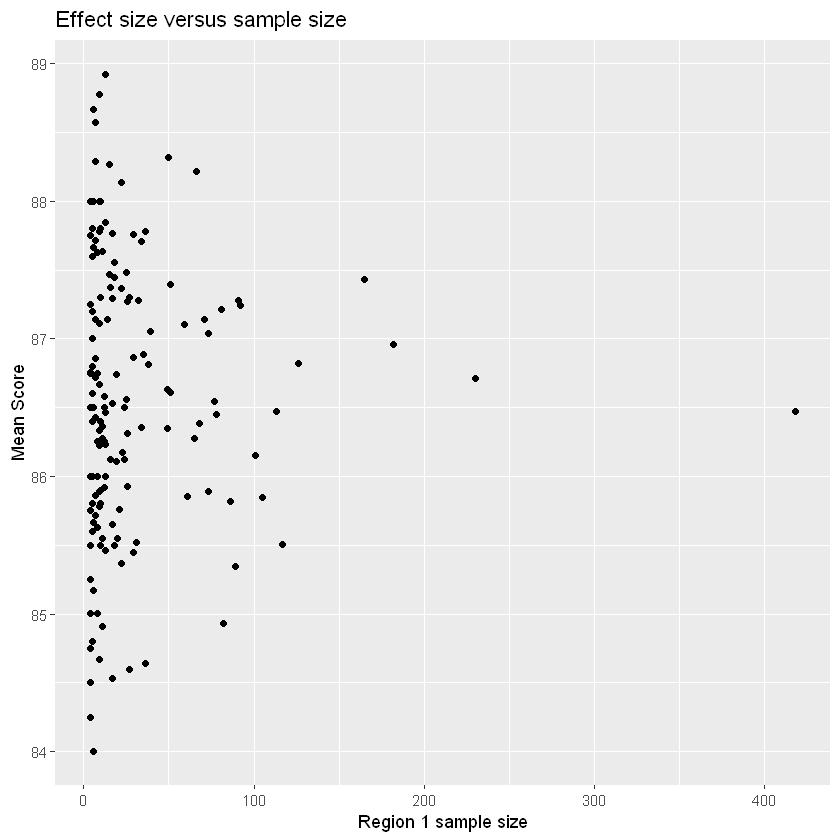

In [17]:
ggplot(data.frame(size = tapply(wine2$points, wine2$region_1, length),
mean_score = tapply(wine2$points, wine2$region_1, mean)), aes(size, mean_score)) +
geom_point() + xlab("Region 1 sample size") + ylab("Mean Score") +
ggtitle("Effect size versus sample size")


In [18]:
compare_m_gibbs <- function(y, ind, mu0 = 50, tau0 = 1/400,
a0 = 1, b0 = 50, alpha0 =1, beta0 = 50, maxiter = 5000)
{
### weakly informative priors
a0 <- 1/2 ; b0 <- 50 ## tau_w hyperparameters
alpha0 <-1/2 ; beta0 <- 50 ## tau_b hyperparameters
mu0<-50 ; tau0 <- 1/25
###
### starting values
m <- nlevels(ind)
ybar <- theta <- tapply(y, ind, mean)
tau_w <- mean(1 / tapply(y, ind, var)) ##within group precision
mu <- mean(theta)

    tau_b <-var(theta) ##between group precision
n_m <- tapply(y, ind, length)
alphan <- alpha0 + sum(n_m)/2
###
### setup MCMC
theta_mat <- matrix(0, nrow=maxiter, ncol=m)
mat_store <- matrix(0, nrow=maxiter, ncol=3)
###
### MCMC algorithm
for(s in 1:maxiter)
{
# sample new values of the thetas
for(j in 1:m)
{
taun <- n_m[j] * tau_w + tau_b
thetan <- (ybar[j] * n_m[j] * tau_w + mu * tau_b) / taun
theta[j]<-rnorm(1, thetan, 1/sqrt(taun))
}
#sample new value of tau_w
ss <- 0
for(j in 1:m){
ss <- ss + sum((y[ind == j] - theta[j])^2)
}
betan <- beta0 + ss/2
tau_w <- rgamma(1, alphan, betan)
#sample a new value of mu
taum <- m * tau_b + tau0
mum <- (mean(theta) * m * tau_b + mu0 * tau0) / taum
mu <- rnorm(1, mum, 1/ sqrt(taum))
# sample a new value of tau_b
am <- a0 + m/2
bm <- b0 + sum((theta - mu)^2) / 2
tau_b <- rgamma(1, am, bm)
#store results
theta_mat[s,] <- theta
mat_store[s, ] <- c(mu, tau_w, tau_b)
}
colnames(mat_store) <- c("mu", "tau_w", "tau_b")
return(list(params = mat_store, theta = theta_mat))
}


In [19]:
wine2$region_1 <- as.factor(wine2$region_1)

In [20]:
fit2 <- compare_m_gibbs(wine2$points, wine2$region_1)


In [21]:
apply(fit2$params, 2, mean)


mu      tau_w      tau_b 
86.5587353 47.0314403  0.6186976

In [22]:
apply(fit2$params, 2, sd)


mu      tau_w      tau_b 
0.10119134 0.98155083 0.06842701

In [23]:
mean(1/sqrt(fit2$params[, 2]))


[1] 0.14584

In [24]:
sd(1/sqrt(fit2$params[, 2]))


[1] 0.001520982

In [25]:
mean(1/sqrt(fit2$params[, 3]))

[1] 1.277199

In [26]:
sd(1/sqrt(fit2$params[, 3]))


[1] 0.07104864

In [27]:
theta_hat <- apply(fit2$theta, 2, mean) ## get basic posterior summary
names(theta_hat) <- 1:100 ## keep track of different schools
sort(theta_hat, decreasing = TRUE) ## which schools did best and worst?


<NA>     <NA>       28     <NA>       76     <NA>       64     <NA> 
88.92122 88.77511 88.66217 88.56827 88.32111 88.28452 88.26545 88.21298 
      51     <NA>       93     <NA>       23     <NA>       55       66 
88.13685 87.99910 87.99830 87.99781 87.99752 87.99522 87.84728 87.79978 
      53       47     <NA>     <NA>        2       80       88       52 
87.79958 87.79841 87.77803 87.77681 87.76429 87.75930 87.74714 87.74696 
      24        5     <NA>       21       91        1       29       72 
87.71448 87.71379 87.70608 87.66554 87.63461 87.62268 87.59918 87.55485 
      35     <NA>     <NA>        4     <NA>       85       18       13 
87.48066 87.46725 87.44486 87.43092 87.39317 87.37532 87.36364 87.30020 
      11       65     <NA>     <NA>     <NA>     <NA>       19       43 
87.29697 87.29467 87.28170 87.27568 87.27054 87.24818 87.24798 87.23987 
    <NA>       34       81       22     <NA>        6       10        8 
87.21085 87.20105 87.14410 87.14276 87.14142 87.11218 87.10290 87.05266 
      89     <NA>       27       31     <NA>       79       41       44 
87.04261 86.99932 86.99848 86.95726 86.88687 86.86240 86.86014 86.81820 
    <NA>     <NA>       83       97        3       26       60       37 
86.81658 86.80082 86.79992 86.75077 86.75040 86.74770 86.73698 86.71404 
    <NA>     <NA>     <NA>     <NA>       15     <NA>       14       63 
86.70987 86.66788 86.63387 86.60929 86.60108 86.58403 86.58394 86.56123 
      90       25        9       12       33       17       87     <NA> 
86.54640 86.53029 86.50194 86.50100 86.50092 86.50025 86.49977 86.46999 
    <NA>     <NA>     <NA>     <NA>       50       42     <NA>       95 
86.46998 86.46303 86.44938 86.43041 86.40115 86.40067 86.38344 86.36586 
    <NA>       48       45     <NA>       40       36     <NA>       59 
86.35435 86.34856 86.33411 86.30925 86.27767 86.27363 86.25124 86.25065 
    <NA>       82       20     <NA>     <NA>     <NA>       74     <NA> 
86.23207 86.22325 86.17460 86.14948 86.12678 86.12522 86.10616 86.00300 
      54       56     <NA>     <NA>     <NA>     <NA>       84     <NA> 
86.00277 86.00184 86.00116 86.00084 85.92411 85.91763 85.90244 85.89157 
    <NA>     <NA>       61       30       86       58     <NA>       32 
85.89080 85.86007 85.85315 85.84868 85.81551 85.80449 85.80359 85.80283 
    <NA>       73       94       69       57     <NA>       16       67 
85.78001 85.76314 85.75367 85.71810 85.67017 85.64824 85.62777 85.60431 
    <NA>     <NA>       98     <NA>       92       96       78       75 
85.55188 85.54780 85.51765 85.50515 85.50384 85.50201 85.50158 85.46287 
    <NA>     <NA>       46       77       71     <NA>       62       38 
85.44938 85.36548 85.34935 85.25689 85.25541 85.17126 85.00972 85.00316 
    <NA>     <NA>       70      100        7     <NA>       99       68 
84.92825 84.91181 84.80598 84.75658 84.67069 84.64012 84.59468 84.53183 
    <NA>       39       49 
84.50710 84.25852 84.00696

In [28]:
theta_ci <- apply(fit2$theta, 2, quantile, prob = c(0.025, .975)) ## upper/lower bounds for thetas
df_error <- data.frame(lower = theta_ci[1, ], upper = theta_ci[2, ], mean = theta_hat,
school = factor(1:100))
ggplot(df_error, aes(x = reorder(school, mean), mean)) + geom_errorbar(aes(ymin = lower, ymax = upper))

ERROR: Error in data.frame(lower = theta_ci[1, ], upper = theta_ci[2, ], mean = theta_hat, : arguments imply differing number of rows: 163, 100


In [ ]:
## reformat samples for ggplot
theta_df <- data.frame(samples = as.numeric(fit2$theta),
school = rep(1:ncol(fit2$theta), each = nrow(fit2$theta)))
ggplot(theta_df) + geom_boxplot(aes(x = reorder(school, samples, median), samples,
fill = reorder(school, samples, median)), show.legend=FALSE)

In [ ]:
ggplot(data.frame(size = tapply(df2$mathscore, df2$school, length), theta_hat = theta_hat),
aes(size, theta_hat)) + geom_point()


In [ ]:
ggplot(data.frame(ybar = tapply(df2$mathscore, df2$school, mean), theta_hat = theta_hat),
aes(ybar, theta_hat)) + geom_point()


In [7]:
wine2 <- wineFullData[ which((wineFullData$price < 20) & (wineFullData$country == "Italy"))  , ]

In [8]:
dim(wine2)

[1] 4895   14

In [9]:
wine2 <- wine2 %>%
  group_by(region_1) %>%
  filter(n() >= 4)

In [10]:
dim(wine2)

[1] 4702   14

In [11]:
wine2 <- droplevels(wine2)

In [12]:
wine2$region_1 <- as.factor(wine2$region_1)

wine2$points <- wine2$points + rnorm(nrow(wine2), 1, 1)/1000

In [13]:
nlevels(wine2$region_1)

[1] 163

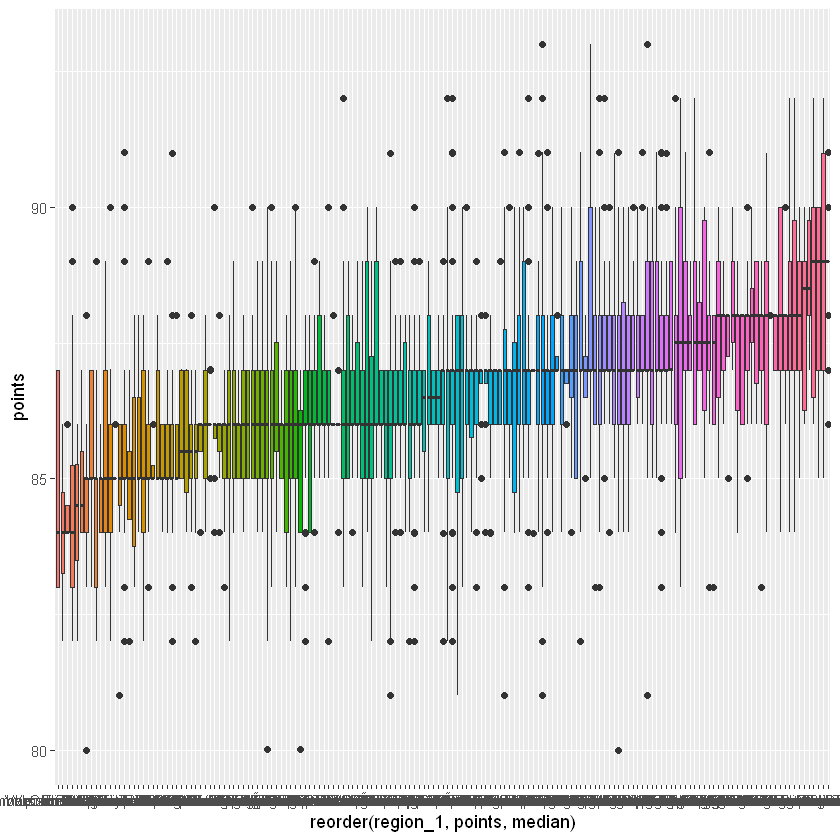

In [14]:
ggplot(wine2) + geom_boxplot(aes(x = reorder(region_1, points, median), points,
fill = reorder(region_1, points, median)), show.legend=FALSE)

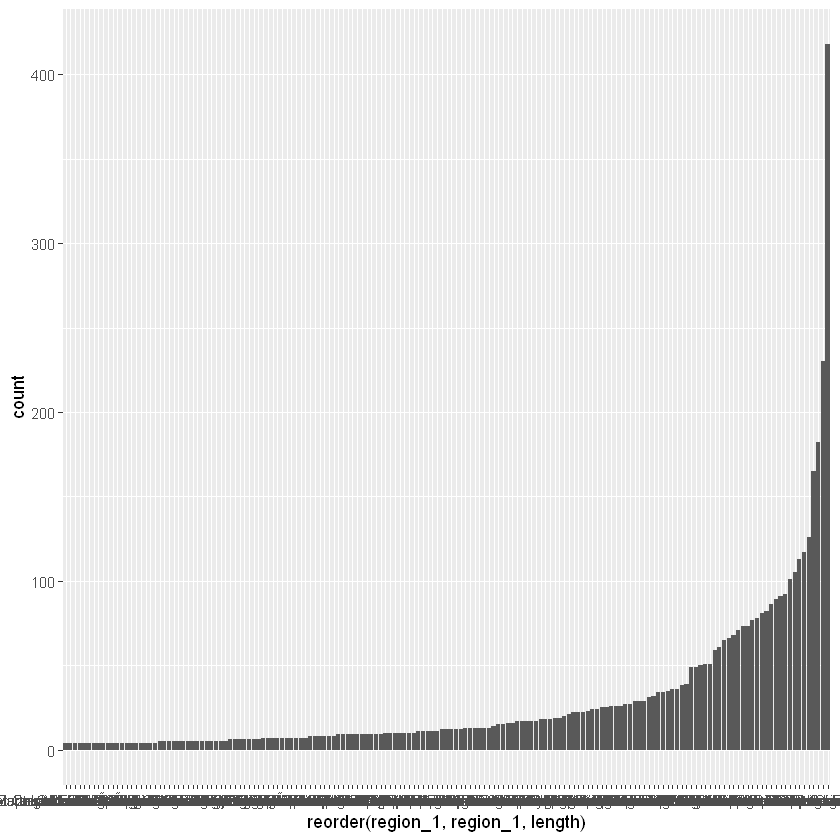

In [15]:
ggplot(wine2, aes(x = reorder(region_1, region_1, length))) + stat_count()


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



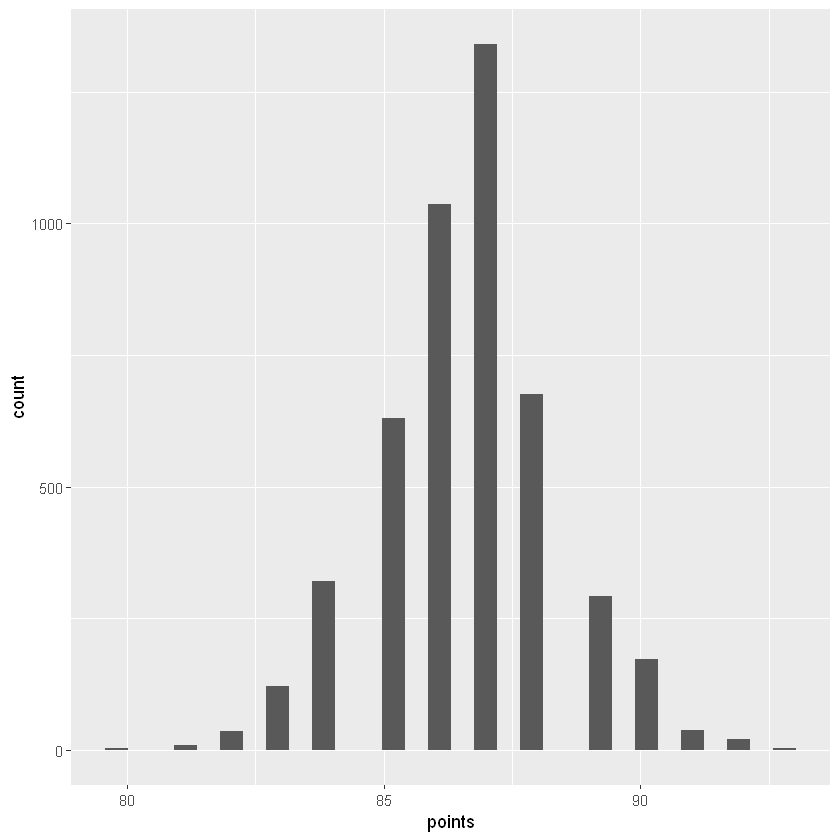

In [16]:
ggplot(wine2, aes(points)) + stat_bin()

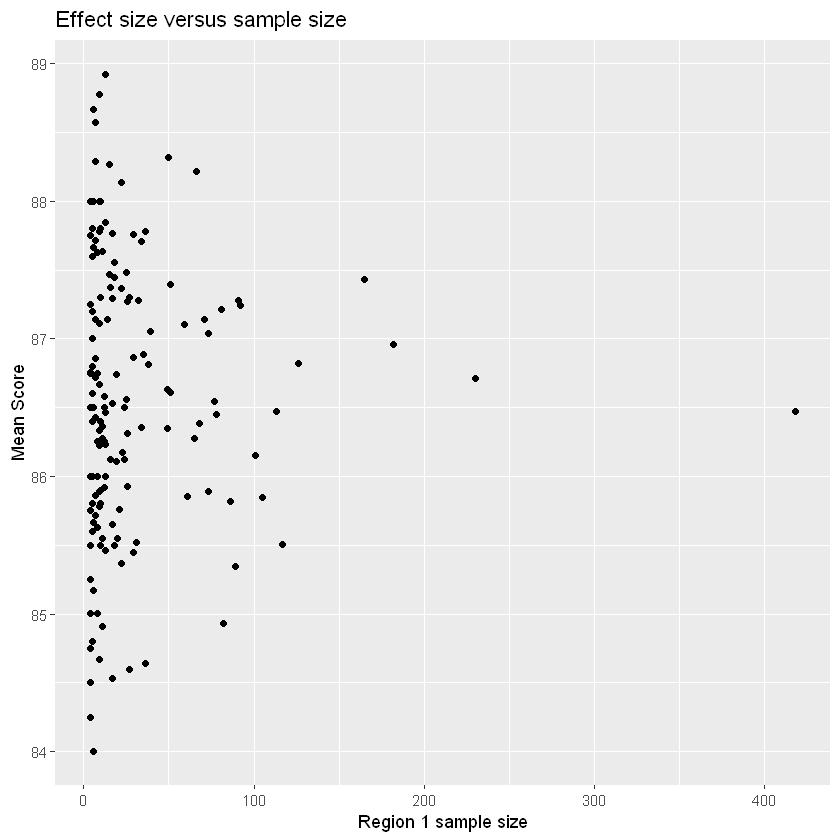

In [17]:
ggplot(data.frame(size = tapply(wine2$points, wine2$region_1, length),
mean_score = tapply(wine2$points, wine2$region_1, mean)), aes(size, mean_score)) +
geom_point() + xlab("Region 1 sample size") + ylab("Mean Score") +
ggtitle("Effect size versus sample size")


In [18]:
compare_m_gibbs <- function(y, ind, mu0 = 50, tau0 = 1/400,
a0 = 1, b0 = 50, alpha0 =1, beta0 = 50, maxiter = 5000)
{
### weakly informative priors
a0 <- 1/2 ; b0 <- 50 ## tau_w hyperparameters
alpha0 <-1/2 ; beta0 <- 50 ## tau_b hyperparameters
mu0<-50 ; tau0 <- 1/25
###
### starting values
m <- nlevels(ind)
ybar <- theta <- tapply(y, ind, mean)
tau_w <- mean(1 / tapply(y, ind, var)) ##within group precision
mu <- mean(theta)

    tau_b <-var(theta) ##between group precision
n_m <- tapply(y, ind, length)
alphan <- alpha0 + sum(n_m)/2
###
### setup MCMC
theta_mat <- matrix(0, nrow=maxiter, ncol=m)
mat_store <- matrix(0, nrow=maxiter, ncol=3)
###
### MCMC algorithm
for(s in 1:maxiter)
{
# sample new values of the thetas
for(j in 1:m)
{
taun <- n_m[j] * tau_w + tau_b
thetan <- (ybar[j] * n_m[j] * tau_w + mu * tau_b) / taun
theta[j]<-rnorm(1, thetan, 1/sqrt(taun))
}
#sample new value of tau_w
ss <- 0
for(j in 1:m){
ss <- ss + sum((y[ind == j] - theta[j])^2)
}
betan <- beta0 + ss/2
tau_w <- rgamma(1, alphan, betan)
#sample a new value of mu
taum <- m * tau_b + tau0
mum <- (mean(theta) * m * tau_b + mu0 * tau0) / taum
mu <- rnorm(1, mum, 1/ sqrt(taum))
# sample a new value of tau_b
am <- a0 + m/2
bm <- b0 + sum((theta - mu)^2) / 2
tau_b <- rgamma(1, am, bm)
#store results
theta_mat[s,] <- theta
mat_store[s, ] <- c(mu, tau_w, tau_b)
}
colnames(mat_store) <- c("mu", "tau_w", "tau_b")
return(list(params = mat_store, theta = theta_mat))
}


In [19]:
wine2$region_1 <- as.factor(wine2$region_1)

In [20]:
fit2 <- compare_m_gibbs(wine2$points, wine2$region_1)


In [21]:
apply(fit2$params, 2, mean)


mu      tau_w      tau_b 
86.5587353 47.0314403  0.6186976

In [22]:
apply(fit2$params, 2, sd)


mu      tau_w      tau_b 
0.10119134 0.98155083 0.06842701

In [23]:
mean(1/sqrt(fit2$params[, 2]))


[1] 0.14584

In [24]:
sd(1/sqrt(fit2$params[, 2]))


[1] 0.001520982

In [25]:
mean(1/sqrt(fit2$params[, 3]))

[1] 1.277199

In [26]:
sd(1/sqrt(fit2$params[, 3]))


[1] 0.07104864

In [27]:
theta_hat <- apply(fit2$theta, 2, mean) ## get basic posterior summary
names(theta_hat) <- 1:100 ## keep track of different schools
sort(theta_hat, decreasing = TRUE) ## which schools did best and worst?


<NA>     <NA>       28     <NA>       76     <NA>       64     <NA> 
88.92122 88.77511 88.66217 88.56827 88.32111 88.28452 88.26545 88.21298 
      51     <NA>       93     <NA>       23     <NA>       55       66 
88.13685 87.99910 87.99830 87.99781 87.99752 87.99522 87.84728 87.79978 
      53       47     <NA>     <NA>        2       80       88       52 
87.79958 87.79841 87.77803 87.77681 87.76429 87.75930 87.74714 87.74696 
      24        5     <NA>       21       91        1       29       72 
87.71448 87.71379 87.70608 87.66554 87.63461 87.62268 87.59918 87.55485 
      35     <NA>     <NA>        4     <NA>       85       18       13 
87.48066 87.46725 87.44486 87.43092 87.39317 87.37532 87.36364 87.30020 
      11       65     <NA>     <NA>     <NA>     <NA>       19       43 
87.29697 87.29467 87.28170 87.27568 87.27054 87.24818 87.24798 87.23987 
    <NA>       34       81       22     <NA>        6       10        8 
87.21085 87.20105 87.14410 87.14276 87.14142 87.11218 87.10290 87.05266 
      89     <NA>       27       31     <NA>       79       41       44 
87.04261 86.99932 86.99848 86.95726 86.88687 86.86240 86.86014 86.81820 
    <NA>     <NA>       83       97        3       26       60       37 
86.81658 86.80082 86.79992 86.75077 86.75040 86.74770 86.73698 86.71404 
    <NA>     <NA>     <NA>     <NA>       15     <NA>       14       63 
86.70987 86.66788 86.63387 86.60929 86.60108 86.58403 86.58394 86.56123 
      90       25        9       12       33       17       87     <NA> 
86.54640 86.53029 86.50194 86.50100 86.50092 86.50025 86.49977 86.46999 
    <NA>     <NA>     <NA>     <NA>       50       42     <NA>       95 
86.46998 86.46303 86.44938 86.43041 86.40115 86.40067 86.38344 86.36586 
    <NA>       48       45     <NA>       40       36     <NA>       59 
86.35435 86.34856 86.33411 86.30925 86.27767 86.27363 86.25124 86.25065 
    <NA>       82       20     <NA>     <NA>     <NA>       74     <NA> 
86.23207 86.22325 86.17460 86.14948 86.12678 86.12522 86.10616 86.00300 
      54       56     <NA>     <NA>     <NA>     <NA>       84     <NA> 
86.00277 86.00184 86.00116 86.00084 85.92411 85.91763 85.90244 85.89157 
    <NA>     <NA>       61       30       86       58     <NA>       32 
85.89080 85.86007 85.85315 85.84868 85.81551 85.80449 85.80359 85.80283 
    <NA>       73       94       69       57     <NA>       16       67 
85.78001 85.76314 85.75367 85.71810 85.67017 85.64824 85.62777 85.60431 
    <NA>     <NA>       98     <NA>       92       96       78       75 
85.55188 85.54780 85.51765 85.50515 85.50384 85.50201 85.50158 85.46287 
    <NA>     <NA>       46       77       71     <NA>       62       38 
85.44938 85.36548 85.34935 85.25689 85.25541 85.17126 85.00972 85.00316 
    <NA>     <NA>       70      100        7     <NA>       99       68 
84.92825 84.91181 84.80598 84.75658 84.67069 84.64012 84.59468 84.53183 
    <NA>       39       49 
84.50710 84.25852 84.00696

In [33]:
# theta_ci <- apply(fit2$theta, 2, quantile, prob = c(0.025, .975)) ## upper/lower bounds for thetas
# df_error <- data.frame(lower = theta_ci[1, ], upper = theta_ci[2, ], mean = theta_hat,
# school = factor(1:100))
# ggplot(df_error, aes(x = reorder(school, mean), mean)) + geom_errorbar(aes(ymin = lower, ymax = upper))

In [ ]:
## reformat samples for ggplot
theta_df <- data.frame(samples = as.numeric(fit2$theta),
school = rep(1:ncol(fit2$theta), each = nrow(fit2$theta)))
ggplot(theta_df) + geom_boxplot(aes(x = reorder(school, samples, median), samples,
fill = reorder(school, samples, median)), show.legend=FALSE)

In [ ]:
ggplot(data.frame(size = tapply(df2$mathscore, df2$school, length), theta_hat = theta_hat),
aes(size, theta_hat)) + geom_point()


In [ ]:
ggplot(data.frame(ybar = tapply(df2$mathscore, df2$school, mean), theta_hat = theta_hat),
aes(ybar, theta_hat)) + geom_point()
